# Phase 7: Advanced GNN Interpretability — Publication Figures\n\nFive publication-ready figures synthesizing Phases 1–7:\n\n1. **Layer-wise class separation** — probing + t-SNE showing where the decision emerges\n2. **Neuron-concept heatmap** — which neurons encode which graph-level concepts\n3. **Cross-method attribution** — feature importance across 4 attribution methods + ablation\n4. **Counterfactual fragility** — minimal edge removals to flip predictions\n5. **PCA embedding space** — where hallu vs truth live in the learned representation

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
from pathlib import Path

from calamr_interp.utils.data_loading import load_dataset, split_dataset
from calamr_interp.utils.model_loading import load_model_checkpoint
from calamr_interp.utils.visualization import setup_style, COLORS
from calamr_interp.phase5_embeddings import (
    LayerEmbeddingExtractor, EmbeddingVisualizer, ProbingClassifier,
)
from calamr_interp.phase7_advanced import NeuronConceptAnalyzer

setup_style()
device = torch.device('cpu')

# Paths
RESULTS_DIR = Path('../results')
FIGURES_DIR = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(exist_ok=True)

# Load model and data
model = load_model_checkpoint(str(RESULTS_DIR / 'hybridgcn/best_model.pt'), 'HybridGCN', device=device)
dataset = load_dataset()
train_sub, val_sub, test_sub = split_dataset(dataset)
all_data = dataset
all_labels = np.array([d.y.item() for d in all_data])
test_data = [test_sub[i] for i in range(len(test_sub))]
test_labels = np.array([d.y.item() for d in test_data])

# Load pre-computed results
with open(RESULTS_DIR / 'phase7_advanced.json') as f:
    p7 = json.load(f)
with open(RESULTS_DIR / 'phase3_ablations.json') as f:
    p3 = json.load(f)
with open(RESULTS_DIR / 'phase4_attribution.json') as f:
    p4 = json.load(f)
with open(RESULTS_DIR / 'phase5_embeddings.json') as f:
    p5 = json.load(f)

print(f'Dataset: {len(dataset)} graphs, Test: {len(test_data)} graphs')
print(f'Model: {type(model).__name__}')

Dataset: 486 graphs, Test: 72 graphs
Model: HybridGCN


---
## Figure 1: Layer-wise Class Separation Emergence

Left: linear probing F1 at each GCN layer. Right: t-SNE at layers 0, 1, 2.

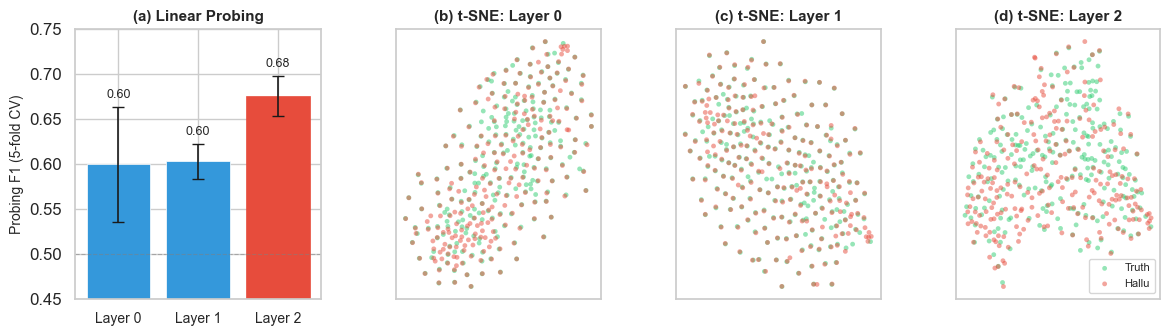

Saved to results/figures/fig1_layer_separation.{pdf,png}


In [2]:
# Extract embeddings
extractor = LayerEmbeddingExtractor(model, device)
extractor.register_hooks()
layer_embeddings = extractor.extract_graph_embeddings(all_data)
extractor.clear_hooks()

layer_names = list(layer_embeddings.keys())
short_names = [f'Layer {i}' for i in range(len(layer_names))]

# Probing results from Phase 5
probe_df = pd.DataFrame(p5['probing'])

# --- Figure ---
fig = plt.figure(figsize=(14, 3.5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.2, 1, 1, 1], wspace=0.35)

# Panel A: Probing bar chart
ax0 = fig.add_subplot(gs[0])
x = np.arange(len(probe_df))
bars = ax0.bar(
    x, probe_df['f1_mean'], yerr=probe_df['f1_std'],
    capsize=4, color=[COLORS['primary']]*3, edgecolor='white', linewidth=0.5,
    error_kw={'linewidth': 1.2}
)
# Highlight the jump at layer 2
bars[2].set_color(COLORS['hallu'])
ax0.axhline(0.5, color='gray', ls='--', lw=0.8, alpha=0.5)
ax0.set_xticks(x)
ax0.set_xticklabels(short_names, fontsize=10)
ax0.set_ylabel('Probing F1 (5-fold CV)', fontsize=10)
ax0.set_ylim(0.45, 0.75)
ax0.set_title('(a) Linear Probing', fontsize=11, fontweight='bold')
for i, row in probe_df.iterrows():
    ax0.text(i, row['f1_mean'] + row['f1_std'] + 0.01,
             f"{row['f1_mean']:.2f}", ha='center', fontsize=9)

# Panels B-D: t-SNE at each layer
viz = EmbeddingVisualizer(seed=42)
panel_labels = ['b', 'c', 'd']
for i, (lname, sname) in enumerate(zip(layer_names, short_names)):
    ax = fig.add_subplot(gs[i + 1])
    emb = layer_embeddings[lname]
    coords = viz.tsne(emb, perplexity=30)

    for label, name, color in [(0, 'Truth', COLORS['truth']), (1, 'Hallu', COLORS['hallu'])]:
        mask = all_labels == label
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=color, label=name, alpha=0.5, s=12, edgecolors='none')

    ax.set_title(f'({panel_labels[i]}) t-SNE: {sname}', fontsize=11, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 2:
        ax.legend(fontsize=8, loc='lower right', framealpha=0.8)

fig.savefig(FIGURES_DIR / 'fig1_layer_separation.pdf', bbox_inches='tight', dpi=300)
fig.savefig(FIGURES_DIR / 'fig1_layer_separation.png', bbox_inches='tight', dpi=300)
plt.show()
print('Saved to results/figures/fig1_layer_separation.{pdf,png}')

---
## Figure 2: Neuron–Concept Correlation Heatmap

Top-20 label-correlated neurons (rows) vs graph-level concepts (columns).  
Color = Pearson/point-biserial *r*, significance indicated by annotation.

In [3]:
# Run neuron-concept analysis (reuses cached embeddings internally)
analyzer = NeuronConceptAnalyzer(model, device=device)
corr_df, selective_df = analyzer.analyze(all_data, top_k=20)
print(f'Total correlations: {len(corr_df)}, Significant: {(corr_df.p_value < 0.05).sum()}')

Total correlations: 8448, Significant: 5512


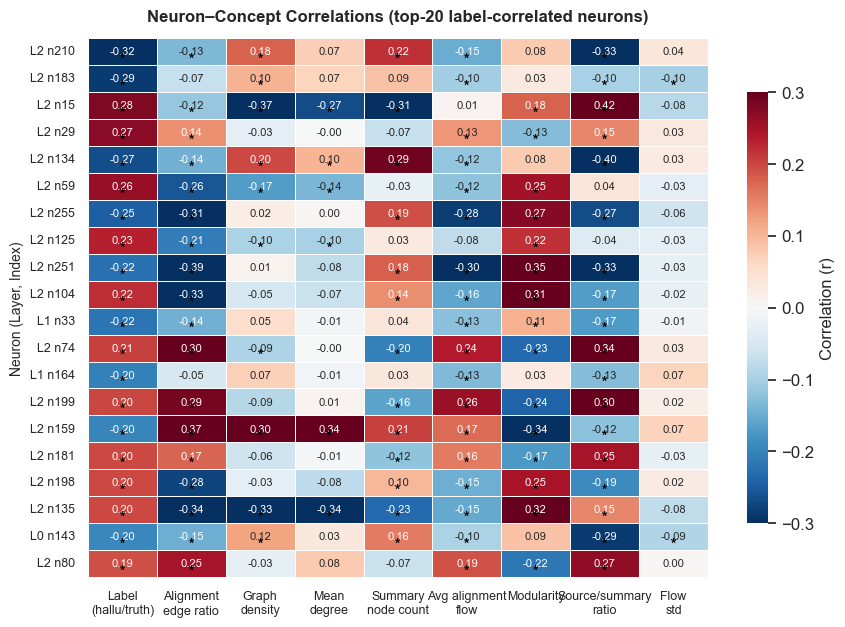

Saved to results/figures/fig2_neuron_concept_heatmap.{pdf,png}


In [4]:
# Select top-20 neurons most correlated with label, across all layers
label_corr = corr_df[corr_df['concept'] == 'label'].copy()
label_corr['abs_r'] = label_corr['correlation_r'].abs()
top_neurons = label_corr.nlargest(20, 'abs_r')[['layer', 'neuron_idx']].values.tolist()

# Concepts to show (curated for readability)
concepts_to_show = [
    'label', 'alignment_edge_ratio', 'graph_density', 'mean_degree',
    'summary_node_count', 'avg_alignment_flow', 'modularity',
    'source_summary_ratio', 'flow_std',
]

# Build heatmap matrix
heatmap_data = np.full((len(top_neurons), len(concepts_to_show)), np.nan)
sig_mask = np.zeros_like(heatmap_data, dtype=bool)
row_labels = []

for ri, (layer, nidx) in enumerate(top_neurons):
    layer_short = layer.replace('gcn_layers.', 'L')
    row_labels.append(f'{layer_short} n{int(nidx)}')
    for ci, concept in enumerate(concepts_to_show):
        match = corr_df[
            (corr_df['layer'] == layer) &
            (corr_df['neuron_idx'] == nidx) &
            (corr_df['concept'] == concept)
        ]
        if len(match) > 0:
            heatmap_data[ri, ci] = match.iloc[0]['correlation_r']
            sig_mask[ri, ci] = match.iloc[0]['p_value'] < 0.05

# Pretty concept names
concept_labels = [
    'Label\n(hallu/truth)', 'Alignment\nedge ratio', 'Graph\ndensity', 'Mean\ndegree',
    'Summary\nnode count', 'Avg alignment\nflow', 'Modularity',
    'Source/summary\nratio', 'Flow\nstd',
]

# --- Figure ---
fig, ax = plt.subplots(figsize=(10, 7))

# Mask NaN for display
hm = sns.heatmap(
    heatmap_data, ax=ax,
    xticklabels=concept_labels, yticklabels=row_labels,
    cmap='RdBu_r', center=0, vmin=-0.3, vmax=0.3,
    annot=True, fmt='.2f', annot_kws={'fontsize': 8},
    linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Correlation (r)', 'shrink': 0.8},
)

# Bold annotations where significant
for ri in range(heatmap_data.shape[0]):
    for ci in range(heatmap_data.shape[1]):
        if sig_mask[ri, ci] and not np.isnan(heatmap_data[ri, ci]):
            ax.text(ci + 0.5, ri + 0.78, '*', ha='center', va='center',
                    fontsize=10, fontweight='bold', color='black')

ax.set_title('Neuron–Concept Correlations (top-20 label-correlated neurons)', fontsize=12, fontweight='bold', pad=12)
ax.set_ylabel('Neuron (Layer, Index)', fontsize=10)
ax.set_xlabel('')
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9, rotation=0)

fig.savefig(FIGURES_DIR / 'fig2_neuron_concept_heatmap.pdf', bbox_inches='tight', dpi=300)
fig.savefig(FIGURES_DIR / 'fig2_neuron_concept_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()
print('Saved to results/figures/fig2_neuron_concept_heatmap.{pdf,png}')

---
## Figure 3: Cross-Method Feature Attribution Comparison

Left: Ablation study (F1 delta when each feature group is removed).  
Right: Attribution methods compared (gradient saliency, IG from Phase 4, Captum IG, Captum Saliency).

<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
/var/folders/1p/4njf_jx53lv6g183nh9d61p40000gn/T/ipykernel_13728/2998792963.py:50: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_xlabel('$\Delta$ F1 from baseline', fontsize=10)


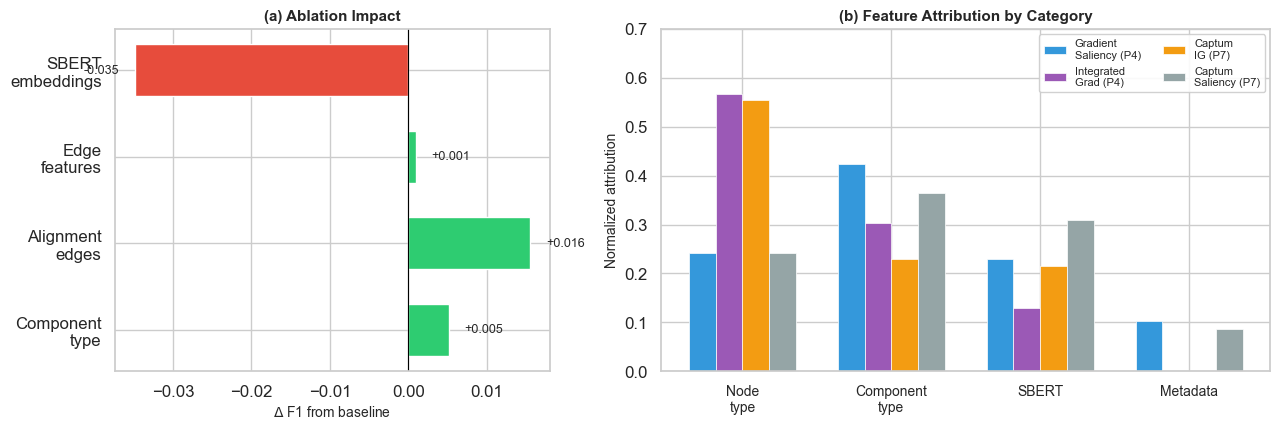

Saved to results/figures/fig3_attribution_comparison.{pdf,png}


In [5]:
# --- Panel A: Ablation F1 deltas ---
# Compute mean F1 across 3 seeds for each condition
def mean_f1(condition_data):
    f1s = [r['f1'] for r in condition_data if r.get('f1', 0) > 0]
    return np.mean(f1s) if f1s else 0.0

baseline_f1 = mean_f1(p3['baseline'])
ablations = {
    'SBERT\nembeddings': mean_f1(p3['A1_no_sbert']) - baseline_f1,
    'Edge\nfeatures': mean_f1(p3['A2_no_edge_features']) - baseline_f1,
    'Alignment\nedges': mean_f1(p3['A3_no_alignment_edges']) - baseline_f1,
    'Component\ntype': mean_f1(p3['A5_no_component_type']) - baseline_f1,
}

# --- Panel B: Attribution methods ---
categories = ['node_type', 'component_type', 'sbert', 'metadata']
cat_labels = ['Node\ntype', 'Component\ntype', 'SBERT', 'Metadata']

# Collect from Phase 4 and Phase 7
methods = {}
# Phase 4: Gradient saliency
gs = p4['gradient_saliency']['node_feature_categories']
methods['Gradient\nSaliency (P4)'] = [gs[c]['mean'] for c in categories]
# Phase 4: Integrated gradients
ig4 = p4['integrated_gradients']['node_feature_categories']
methods['Integrated\nGrad (P4)'] = [ig4[c]['mean'] for c in categories]
# Phase 7: Captum IG
captum_ig = [r for r in p7['captum'] if r['method'] == 'IntegratedGradients'][0]
methods['Captum\nIG (P7)'] = [captum_ig[f'{c}_mean'] for c in categories]
# Phase 7: Captum Saliency
captum_sal = [r for r in p7['captum'] if r['method'] == 'Saliency'][0]
methods['Captum\nSaliency (P7)'] = [captum_sal[f'{c}_mean'] for c in categories]

# Normalize each method to sum to 1 for comparability
methods_norm = {}
for mname, vals in methods.items():
    total = sum(vals)
    methods_norm[mname] = [v / total if total > 0 else 0.25 for v in vals]

# --- Figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5), gridspec_kw={'width_ratios': [1, 1.4]})

# Panel A: Ablation waterfall
abl_names = list(ablations.keys())
abl_vals = list(ablations.values())
abl_colors = [COLORS['hallu'] if v < 0 else COLORS['truth'] for v in abl_vals]

bars = ax1.barh(abl_names, abl_vals, color=abl_colors, edgecolor='white', height=0.6)
ax1.axvline(0, color='black', lw=0.8)
ax1.set_xlabel('$\Delta$ F1 from baseline', fontsize=10)
ax1.set_title('(a) Ablation Impact', fontsize=11, fontweight='bold')
ax1.invert_yaxis()
for bar, val in zip(bars, abl_vals):
    x_pos = val + (0.002 if val >= 0 else -0.002)
    ha = 'left' if val >= 0 else 'right'
    ax1.text(x_pos, bar.get_y() + bar.get_height()/2,
             f'{val:+.3f}', ha=ha, va='center', fontsize=9)

# Panel B: Grouped bar chart of normalized attribution
x = np.arange(len(cat_labels))
n_methods = len(methods_norm)
width = 0.18
method_colors = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['neutral']]

for i, (mname, vals) in enumerate(methods_norm.items()):
    offset = (i - n_methods/2 + 0.5) * width
    ax2.bar(x + offset, vals, width, label=mname, color=method_colors[i],
            edgecolor='white', linewidth=0.5)

ax2.set_xticks(x)
ax2.set_xticklabels(cat_labels, fontsize=10)
ax2.set_ylabel('Normalized attribution', fontsize=10)
ax2.set_title('(b) Feature Attribution by Category', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8, loc='upper right', ncol=2, framealpha=0.9)
ax2.set_ylim(0, 0.7)

fig.tight_layout()
fig.savefig(FIGURES_DIR / 'fig3_attribution_comparison.pdf', bbox_inches='tight', dpi=300)
fig.savefig(FIGURES_DIR / 'fig3_attribution_comparison.png', bbox_inches='tight', dpi=300)
plt.show()
print('Saved to results/figures/fig3_attribution_comparison.{pdf,png}')

---
## Figure 4: Counterfactual Fragility

Left: Distribution of edge removal fraction needed to flip predictions.  
Right: Composition of removed edges (internal vs alignment).

In [6]:
cf = p7['counterfactual']
cf_summary = cf['flipped_summary']

# We need per-graph data for the histogram. Re-run counterfactual on test set.
from calamr_interp.phase7_advanced import CounterfactualExplainer

cf_explainer = CounterfactualExplainer(model, device=device)
cf_df = cf_explainer.run(test_data[:50])
print(f'Counterfactual: {len(cf_df)} graphs, flip rate: {cf_df["flipped"].mean():.0%}')

Counterfactual: 50 graphs, flip rate: 100%


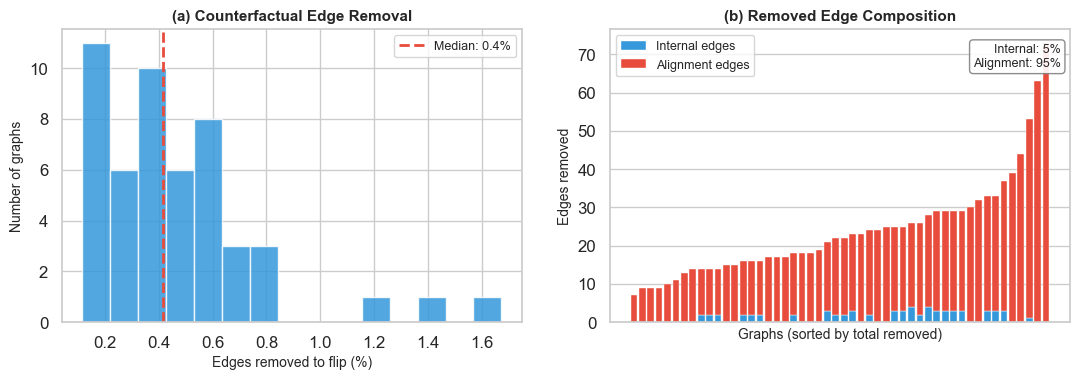

Saved to results/figures/fig4_counterfactual_fragility.{pdf,png}


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# --- Panel A: Histogram of removal fractions ---
flipped = cf_df[cf_df['flipped']]
ax1.hist(flipped['removal_fraction'] * 100, bins=15, color=COLORS['primary'],
         edgecolor='white', alpha=0.85)
median_frac = flipped['removal_fraction'].median() * 100
ax1.axvline(median_frac, color=COLORS['hallu'], ls='--', lw=2,
            label=f'Median: {median_frac:.1f}%')
ax1.set_xlabel('Edges removed to flip (%)', fontsize=10)
ax1.set_ylabel('Number of graphs', fontsize=10)
ax1.set_title('(a) Counterfactual Edge Removal', fontsize=11, fontweight='bold')
ax1.legend(fontsize=9)

# --- Panel B: Composition of removed edges ---
# Per-graph stacked bar, sorted by total removed
sorted_cf = flipped.sort_values('n_edges_removed').reset_index(drop=True)
x = np.arange(len(sorted_cf))

ax2.bar(x, sorted_cf['n_removed_internal'], label='Internal edges',
        color=COLORS['primary'], edgecolor='white', linewidth=0.3)
ax2.bar(x, sorted_cf['n_removed_alignment'], bottom=sorted_cf['n_removed_internal'],
        label='Alignment edges', color=COLORS['hallu'], edgecolor='white', linewidth=0.3)

ax2.set_xlabel('Graphs (sorted by total removed)', fontsize=10)
ax2.set_ylabel('Edges removed', fontsize=10)
ax2.set_title('(b) Removed Edge Composition', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.set_xticks([])

# Summary annotation
total_int = flipped['n_removed_internal'].sum()
total_align = flipped['n_removed_alignment'].sum()
pct_int = total_int / (total_int + total_align) * 100
ax2.text(0.98, 0.95, f'Internal: {pct_int:.0f}%\nAlignment: {100-pct_int:.0f}%',
         transform=ax2.transAxes, ha='right', va='top', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.9))

fig.tight_layout()
fig.savefig(FIGURES_DIR / 'fig4_counterfactual_fragility.pdf', bbox_inches='tight', dpi=300)
fig.savefig(FIGURES_DIR / 'fig4_counterfactual_fragility.png', bbox_inches='tight', dpi=300)
plt.show()
print('Saved to results/figures/fig4_counterfactual_fragility.{pdf,png}')

---
## Summary Table

Key numbers for the paper text.

In [8]:
summary = pd.DataFrame([
    {'Finding': 'Probing F1 (Layer 0 → 2)', 'Value': f"{probe_df.iloc[0]['f1_mean']:.2f} → {probe_df.iloc[-1]['f1_mean']:.2f}"},
    {'Finding': 'Top neuron-label correlation', 'Value': f"r={p7['neuron_concept']['top_label_neurons'][0]['correlation_r']:.3f} (L2, n{p7['neuron_concept']['top_label_neurons'][0]['neuron_idx']})"},
    {'Finding': 'Significant neuron-concept pairs', 'Value': f"{p7['neuron_concept']['n_significant']}/{p7['neuron_concept']['n_total_correlations']}"},
    {'Finding': 'SBERT ablation effect', 'Value': f"ΔF1 = {mean_f1(p3['A1_no_sbert']) - baseline_f1:+.3f}"},
    {'Finding': 'Alignment edge ablation', 'Value': f"ΔF1 = {mean_f1(p3['A3_no_alignment_edges']) - baseline_f1:+.3f}"},
    {'Finding': 'Counterfactual flip rate', 'Value': f"{cf_df['flipped'].mean():.0%} (avg {cf_df['removal_fraction'].mean()*100:.1f}% edges)"},
    {'Finding': 'Removed edges: internal vs align', 'Value': f"{cf_df['n_removed_internal'].mean():.0f} internal, {cf_df['n_removed_alignment'].mean():.0f} alignment"},
])
summary.style.hide(axis='index')

Finding,Value
Probing F1 (Layer 0 → 2),0.60 → 0.68
Top neuron-label correlation,"r=0.279 (L2, n15)"
Significant neuron-concept pairs,5512/8448
SBERT ablation effect,ΔF1 = -0.035
Alignment edge ablation,ΔF1 = +0.016
Counterfactual flip rate,100% (avg 0.5% edges)
Removed edges: internal vs align,"1 internal, 23 alignment"


---\n## Figure 5: PCA Embedding Space\n\nPCA on the final-layer (Layer 2) graph embeddings. Unlike t-SNE, PCA is deterministic,\npreserves global geometry, and gives interpretable axes with explained variance ratios.\n\n- (a) PC1 vs PC2 scatter — shows the principal plane of variation\n- (b) PC1 distribution by class — the main axis of linear separation\n- (c) Layer-wise PCA — how the principal components evolve across layers

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- PCA at each layer ---
pca_results = {}
for lname in layer_names:
    emb = layer_embeddings[lname]
    # Standardize before PCA (important since embeddings are in a narrow cone)
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)
    pca = PCA(n_components=min(10, emb_scaled.shape[1]))
    coords = pca.fit_transform(emb_scaled)
    pca_results[lname] = {
        'coords': coords,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'components': pca.components_,
    }
    evr = pca.explained_variance_ratio_
    print(f'{lname}: PC1={evr[0]:.1%}, PC2={evr[1]:.1%}, cumulative top-5={sum(evr[:5]):.1%}')

gcn_layers.0: PC1=36.9%, PC2=3.8%, cumulative top-5=49.2%
gcn_layers.1: PC1=34.0%, PC2=6.9%, cumulative top-5=53.6%
gcn_layers.2: PC1=63.6%, PC2=7.0%, cumulative top-5=78.7%


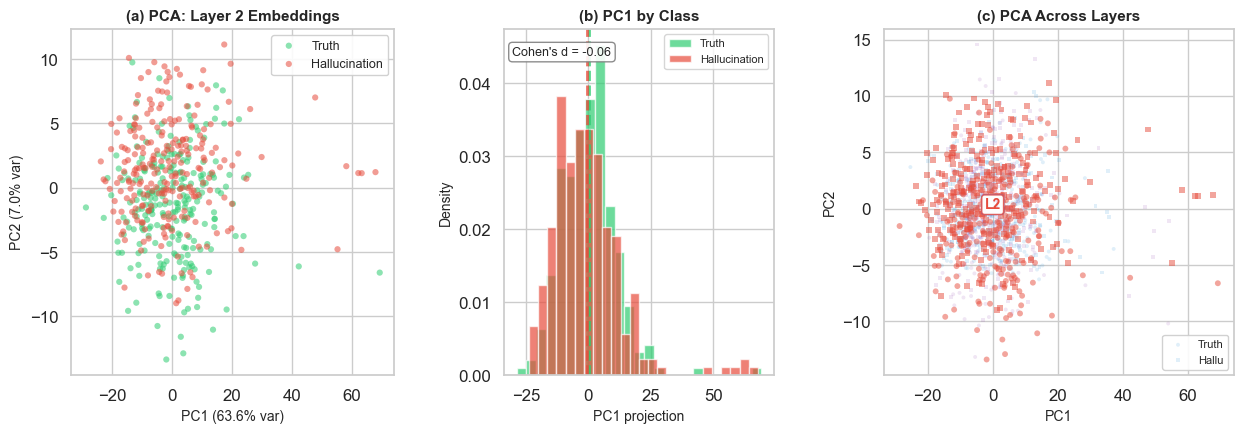

Saved to results/figures/fig5_pca_embeddings.{pdf,png}


In [10]:
fig = plt.figure(figsize=(15, 4.5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1.3], wspace=0.35)

# Use final layer for panels (a) and (b)
final_layer = layer_names[-1]
final_pca = pca_results[final_layer]
pc_coords = final_pca['coords']
evr = final_pca['explained_variance_ratio']

# --- Panel A: PC1 vs PC2 scatter ---
ax1 = fig.add_subplot(gs[0])
for label, name, color in [(0, 'Truth', COLORS['truth']), (1, 'Hallucination', COLORS['hallu'])]:
    mask = all_labels == label
    ax1.scatter(pc_coords[mask, 0], pc_coords[mask, 1],
                c=color, label=name, alpha=0.55, s=20, edgecolors='none')

ax1.set_xlabel(f'PC1 ({evr[0]:.1%} var)', fontsize=10)
ax1.set_ylabel(f'PC2 ({evr[1]:.1%} var)', fontsize=10)
ax1.set_title('(a) PCA: Layer 2 Embeddings', fontsize=11, fontweight='bold')
ax1.legend(fontsize=9, loc='best', framealpha=0.9)

# --- Panel B: PC1 distribution by class ---
ax2 = fig.add_subplot(gs[1])
truth_pc1 = pc_coords[all_labels == 0, 0]
hallu_pc1 = pc_coords[all_labels == 1, 0]

ax2.hist(truth_pc1, bins=25, alpha=0.7, color=COLORS['truth'], label='Truth', density=True)
ax2.hist(hallu_pc1, bins=25, alpha=0.7, color=COLORS['hallu'], label='Hallucination', density=True)
ax2.axvline(truth_pc1.mean(), color=COLORS['truth'], ls='--', lw=2, alpha=0.8)
ax2.axvline(hallu_pc1.mean(), color=COLORS['hallu'], ls='--', lw=2, alpha=0.8)

# Cohen's d for PC1
pooled_std = np.sqrt((truth_pc1.std()**2 + hallu_pc1.std()**2) / 2)
cohens_d = (hallu_pc1.mean() - truth_pc1.mean()) / pooled_std
ax2.set_xlabel(f'PC1 projection', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title('(b) PC1 by Class', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.text(0.03, 0.95, f"Cohen's d = {cohens_d:.2f}", transform=ax2.transAxes,
         fontsize=9, va='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.9))

# --- Panel C: Layer-wise PCA scatter (PC1 vs PC2 at each layer) ---
ax3 = fig.add_subplot(gs[2])
layer_colors_map = {0: COLORS['primary'], 1: COLORS['secondary'], 2: COLORS['hallu']}

for li, lname in enumerate(layer_names):
    coords = pca_results[lname]['coords']
    levr = pca_results[lname]['explained_variance_ratio']

    for label, marker in [(0, 'o'), (1, 's')]:
        mask = all_labels == label
        alpha = 0.15 if li < len(layer_names) - 1 else 0.5
        size = 8 if li < len(layer_names) - 1 else 18
        label_str = None
        if label == 0 and li == 0:
            label_str = 'Truth'
        elif label == 1 and li == 0:
            label_str = 'Hallu'
        ax3.scatter(coords[mask, 0], coords[mask, 1],
                    c=layer_colors_map[li], marker=marker, alpha=alpha, s=size,
                    edgecolors='none', label=label_str)

    # Add layer label
    cx, cy = coords[:, 0].mean(), coords[:, 1].mean()
    ax3.annotate(f'L{li}', (cx, cy), fontsize=10, fontweight='bold',
                 color=layer_colors_map[li], ha='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor=layer_colors_map[li]))

ax3.set_xlabel('PC1', fontsize=10)
ax3.set_ylabel('PC2', fontsize=10)
ax3.set_title('(c) PCA Across Layers', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8, loc='lower right', framealpha=0.9)

fig.savefig(FIGURES_DIR / 'fig5_pca_embeddings.pdf', bbox_inches='tight', dpi=300)
fig.savefig(FIGURES_DIR / 'fig5_pca_embeddings.png', bbox_inches='tight', dpi=300)
plt.show()
print('Saved to results/figures/fig5_pca_embeddings.{pdf,png}')